# Fake News Detection - Phase 5: Optimisation et Évaluation des Modèles Classiques

### Objectifs de ce notebook

**Objectif** : Optimiser les hyperparamètres des modèles classiques via GridSearchCV, évaluer leurs performances sur les données de test, sauvegarder les modèles optimisés et comparer avec les modèles non optimisés.

**Contenu** :
- Chargement des données preprocessées
- Optimisation des hyperparamètres (GridSearchCV)
- Évaluation sur les données de test
- Sauvegarde des modèles (pickle) et performances (Excel)
- Comparaison modèles optimisés vs non optimisés

## 1 Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
from datetime import datetime

# Machine Learning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix
)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print(" Bibliothèques importées avec succès")

 Bibliothèques importées avec succès


## 2 Chargement des données

In [12]:
# Chargement des datasets
processed = "../data/processed/"
classical = "../models/classical/"

train_df = pd.read_csv(processed + "train.csv")
val_df = pd.read_csv(processed + "validation.csv")
test_df = pd.read_csv(processed + "test.csv")

print(f"Training set:   {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set:       {len(test_df):,} samples")

Training set:   24,728 samples
Validation set: 6,183 samples
Test set:       7,728 samples


In [13]:
# Preparation des donnees
X_train = train_df['text'].values
y_train = train_df['label'].values

X_val = val_df['text'].values
y_val = val_df['label'].values

X_test = test_df['text'].values
y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (24728,)
y_train shape: (24728,)


In [14]:
# Load the vectorizer that was used during training
with open('../models/classical/tfidf_vectorizer.pkl', 'rb') as f:  
    vectorizer = pickle.load(f)

X_train= vectorizer.transform(X_train)
X_test= vectorizer.transform(X_test)

## 3 Chargement des modèles de base (non optimisés)

In [15]:
baseline_results = {}

models_baseline = {
    'LinearSVC': "../models/classical/linear_svm.pkl",
    'RandomForest': "../models/classical/random_forest.pkl",
    'NaiveBayes': "../models/classical/naive_bayes.pkl",
    'LogisticRegression': '../models/classical/logistic_regression.pkl'
}

# Now use the transformed data for predictions
for name, path in models_baseline.items():
    try:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        y_pred = model.predict(X_test)  # Use transformed data
        baseline_results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
    except FileNotFoundError:
        print(f"Modèle {name} non trouvé, sera ignoré dans la comparaison")

## 4 Optimisation des hyperparamètres

Utilisation de GridSearchCV avec validation croisée 5-fold pour trouver les meilleurs hyperparamètres.

### 4.1 Linear SVM

In [18]:
print("Optimisation de Linear SVM...")

# Grille d'hyperparamètres
param_grid_svm = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000]
}

# GridSearch
grid_svm = GridSearchCV(
    LinearSVC(random_state=42, dual='auto'),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_svm.best_params_}")
print(f"Meilleur score CV: {grid_svm.best_score_:.4f}")

# Sauvegarde
with open('../models/classic_ops/linear_svc_optimized.pkl', 'wb') as f:
    pickle.dump(grid_svm.best_estimator_, f)

print(" Modèle sauvegardé")

Optimisation de Linear SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 1000}
Meilleur score CV: 0.9956
 Modèle sauvegardé


### 4.2 Random Forest

In [19]:
print("Optimisation de Random Forest...")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_rf.best_params_}")
print(f"Meilleur score CV: {grid_rf.best_score_:.4f}")

with open('../models/classic_ops/random_forest_optimized.pkl', 'wb') as f:
    pickle.dump(grid_rf.best_estimator_, f)

print(" Modèle sauvegardé")

Optimisation de Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Meilleur score CV: 0.9962
 Modèle sauvegardé


### 4.3 Naive Bayes

In [20]:
print("Optimisation de Naive Bayes...")

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

grid_nb = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=5,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_nb.best_params_}")
print(f"Meilleur score CV: {grid_nb.best_score_:.4f}")

with open('../models/classic_ops/naive_bayes_optimized.pkl', 'wb') as f:
    pickle.dump(grid_nb.best_estimator_, f)

print("Modèle sauvegardé")

Optimisation de Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres: {'alpha': 0.1, 'fit_prior': False}
Meilleur score CV: 0.9583
Modèle sauvegardé


### 4.4 Logistic Regression

In [21]:
print("Optimisation de Logistic Regression...")

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000, 2000]
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=5,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_lr.best_params_}")
print(f"Meilleur score CV: {grid_lr.best_score_:.4f}")

with open('../models/classic_ops/logistic_regression_optimized.pkl', 'wb') as f:
    pickle.dump(grid_lr.best_estimator_, f)

print(" Modèle sauvegardé")

Optimisation de Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score CV: 0.9932
 Modèle sauvegardé


## 5 Évaluation sur les données de test

In [22]:
# Dictionnaire pour stocker les modèles optimisés
optimized_models = {
    'LinearSVC': grid_svm.best_estimator_,
    'RandomForest': grid_rf.best_estimator_,
    'NaiveBayes': grid_nb.best_estimator_,
    'LogisticRegression': grid_lr.best_estimator_
}

# Évaluation de chaque modèle
optimized_results = {}

for name, model in optimized_models.items():
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    optimized_results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'predictions': y_pred
    }
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred, 
                                target_names=['True News', 'Fake News']))

print("Évaluation terminée")

Accuracy:  0.9964
Precision: 0.9967
Recall:    0.9967
F1-Score:  0.9967
Rapport de classification:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      3490
   Fake News       1.00      1.00      1.00      4238

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728

Accuracy:  0.9972
Precision: 0.9969
Recall:    0.9979
F1-Score:  0.9974
Rapport de classification:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      3490
   Fake News       1.00      1.00      1.00      4238

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728

Accuracy:  0.9604
Precision: 0.9703
Recall:    0.9571
F1-Score:  0.9636
Rapport de classification:
              precision    recall  f1-score   sup

## 6 Matrices de confusion

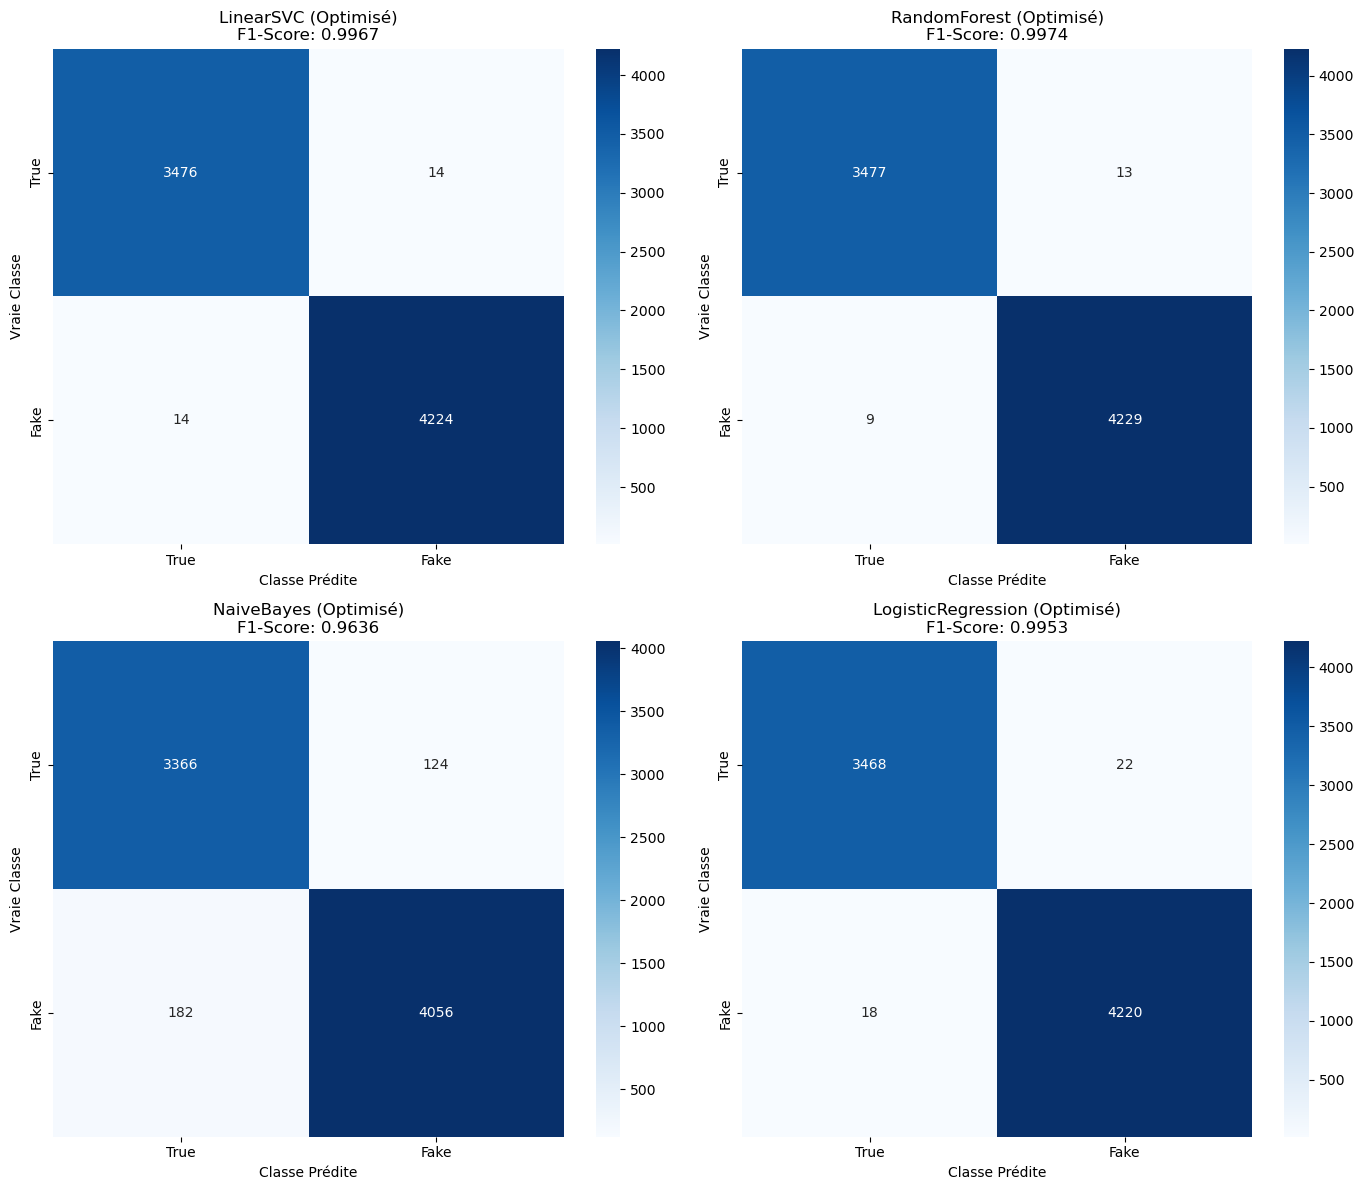

Matrices de confusion sauvegardées


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, results) in enumerate(optimized_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['True', 'Fake'],
                yticklabels=['True', 'Fake'],
                ax=axes[idx])
    
    axes[idx].set_title(f'{name} (Optimisé)\nF1-Score: {results["f1"]:.4f}')
    axes[idx].set_ylabel('Vraie Classe')
    axes[idx].set_xlabel('Classe Prédite')

plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrices_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Matrices de confusion sauvegardées")

## 7 Comparaison modèles optimisés vs non optimisés

In [26]:
import json

# Trouver le meilleur modèle parmi tous (baseline + optimisés + deep learning)
all_results = []

# Modèles classiques
for model_name in optimized_results.keys():
    if model_name in baseline_results:
        all_results.append({
            'Modèle': f"{model_name} (Baseline)",
            'Accuracy': baseline_results[model_name]['accuracy'],
            'Precision': baseline_results[model_name]['precision'],
            'Recall': baseline_results[model_name]['recall']
        })
    
    all_results.append({
        'Modèle': f"{model_name} (Optimisé)",
        'Accuracy': optimized_results[model_name]['accuracy'],
        'Precision': optimized_results[model_name]['precision'],
        'Recall': optimized_results[model_name]['recall']
    })

# Modèles Deep Learning
deep_models = {
    'CNN': '../models/deep/cnn_metrics.json',
    'BiLSTM': '../models/deep/bilstm_metrics.json'
}

for model_name, json_path in deep_models.items():
    try:
        with open(json_path, 'r') as f:
            metrics = json.load(f)
        
        all_results.append({
            'Modèle': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall']
        })
        print(f" {model_name} chargé")
    except FileNotFoundError:
        print(f" {json_path} non trouvé")
    except KeyError as e:
        print(f" Clé manquante dans {model_name}: {e}")

# Trier et afficher
df_all = pd.DataFrame(all_results).sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("CLASSEMENT COMPLET DES MODÈLES (par Accuracy)")
print("="*80)
print(df_all.to_string(index=False))

# Top 3
print("\n" + "="*80)
print(" TOP 3 MEILLEURS MODÈLES")
print("="*80)
for i in range(min(3, len(df_all))):
    model = df_all.iloc[i]
    print(f"\n#{i+1} - {model['Modèle']}")
    print(f"   Accuracy:  {model['Accuracy']:.4f}")
    print(f"   Precision: {model['Precision']:.4f}")
    print(f"   Recall:    {model['Recall']:.4f}")
print("="*80)

 CNN chargé
 BiLSTM chargé

CLASSEMENT COMPLET DES MODÈLES (par Accuracy)
                       Modèle  Accuracy  Precision   Recall
                       BiLSTM  0.999920   0.999853 0.999853
      RandomForest (Optimisé)  0.997153   0.996935 0.997876
      RandomForest (Baseline)  0.996765   0.995530 0.998584
         LinearSVC (Optimisé)  0.996377   0.996697 0.996697
         LinearSVC (Baseline)  0.995989   0.996226 0.996461
LogisticRegression (Optimisé)  0.994824   0.994814 0.995753
LogisticRegression (Baseline)  0.990295   0.988730 0.993629
                          CNN  0.989132   0.989166 0.991034
        NaiveBayes (Optimisé)  0.960404   0.970335 0.957055
        NaiveBayes (Baseline)  0.957169   0.965452 0.956111

 TOP 3 MEILLEURS MODÈLES

#1 - BiLSTM
   Accuracy:  0.9999
   Precision: 0.9999
   Recall:    0.9999

#2 - RandomForest (Optimisé)
   Accuracy:  0.9972
   Precision: 0.9969
   Recall:    0.9979

#3 - RandomForest (Baseline)
   Accuracy:  0.9968
   Precision: 0.9955

In [ ]:
# Créer un DataFrame de comparaison
comparison_data = []

for model_name in optimized_results.keys():
    # Baseline
    if model_name in baseline_results:
        comparison_data.append({
            'Modèle': model_name,
            'Version': 'Baseline',
            'Accuracy': baseline_results[model_name]['accuracy'],
            'Precision': baseline_results[model_name]['precision'],
            'Recall': baseline_results[model_name]['recall']
        })
    
    # Optimisé
    comparison_data.append({
        'Modèle': model_name,
        'Version': 'Optimisé',
        'Accuracy': optimized_results[model_name]['accuracy'],
        'Precision': optimized_results[model_name]['precision'],
        'Recall': optimized_results[model_name]['recall']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nComparaison des performances:")
print(df_comparison.to_string(index=False))

# Calcul des améliorations
print("Améliorations apportées par l'optimisation:")

for model_name in optimized_results.keys():
    if model_name in baseline_results:
        accuracy_base = baseline_results[model_name]['accuracy']
        accuracy_opt = optimized_results[model_name]['accuracy']
        improvement = ((accuracy_opt - accuracy_base) / accuracy_base) * 100
        
        print(f"\n{model_name}:")
        print(f"  accuracy Baseline: {accuracy_base:.4f}")
        print(f"  accuracy Optimisé: {accuracy_opt:.4f}")
        print(f"  Amélioration: {improvement:+.2f}%")


Comparaison des performances:
            Modèle  Version  Accuracy  Precision   Recall
         LinearSVC Baseline  0.995989   0.996226 0.996461
         LinearSVC Optimisé  0.996377   0.996697 0.996697
      RandomForest Baseline  0.996765   0.995530 0.998584
      RandomForest Optimisé  0.997153   0.996935 0.997876
        NaiveBayes Baseline  0.957169   0.965452 0.956111
        NaiveBayes Optimisé  0.960404   0.970335 0.957055
LogisticRegression Baseline  0.990295   0.988730 0.993629
LogisticRegression Optimisé  0.994824   0.994814 0.995753
Améliorations apportées par l'optimisation:

LinearSVC:
  accuracy Baseline: 0.9960
  accuracy Optimisé: 0.9964
  Amélioration: +0.04%

RandomForest:
  accuracy Baseline: 0.9968
  accuracy Optimisé: 0.9972
  Amélioration: +0.04%

NaiveBayes:
  accuracy Baseline: 0.9572
  accuracy Optimisé: 0.9604
  Amélioration: +0.34%

LogisticRegression:
  accuracy Baseline: 0.9903
  accuracy Optimisé: 0.9948
  Amélioration: +0.46%


## 8 Visualisation comparative

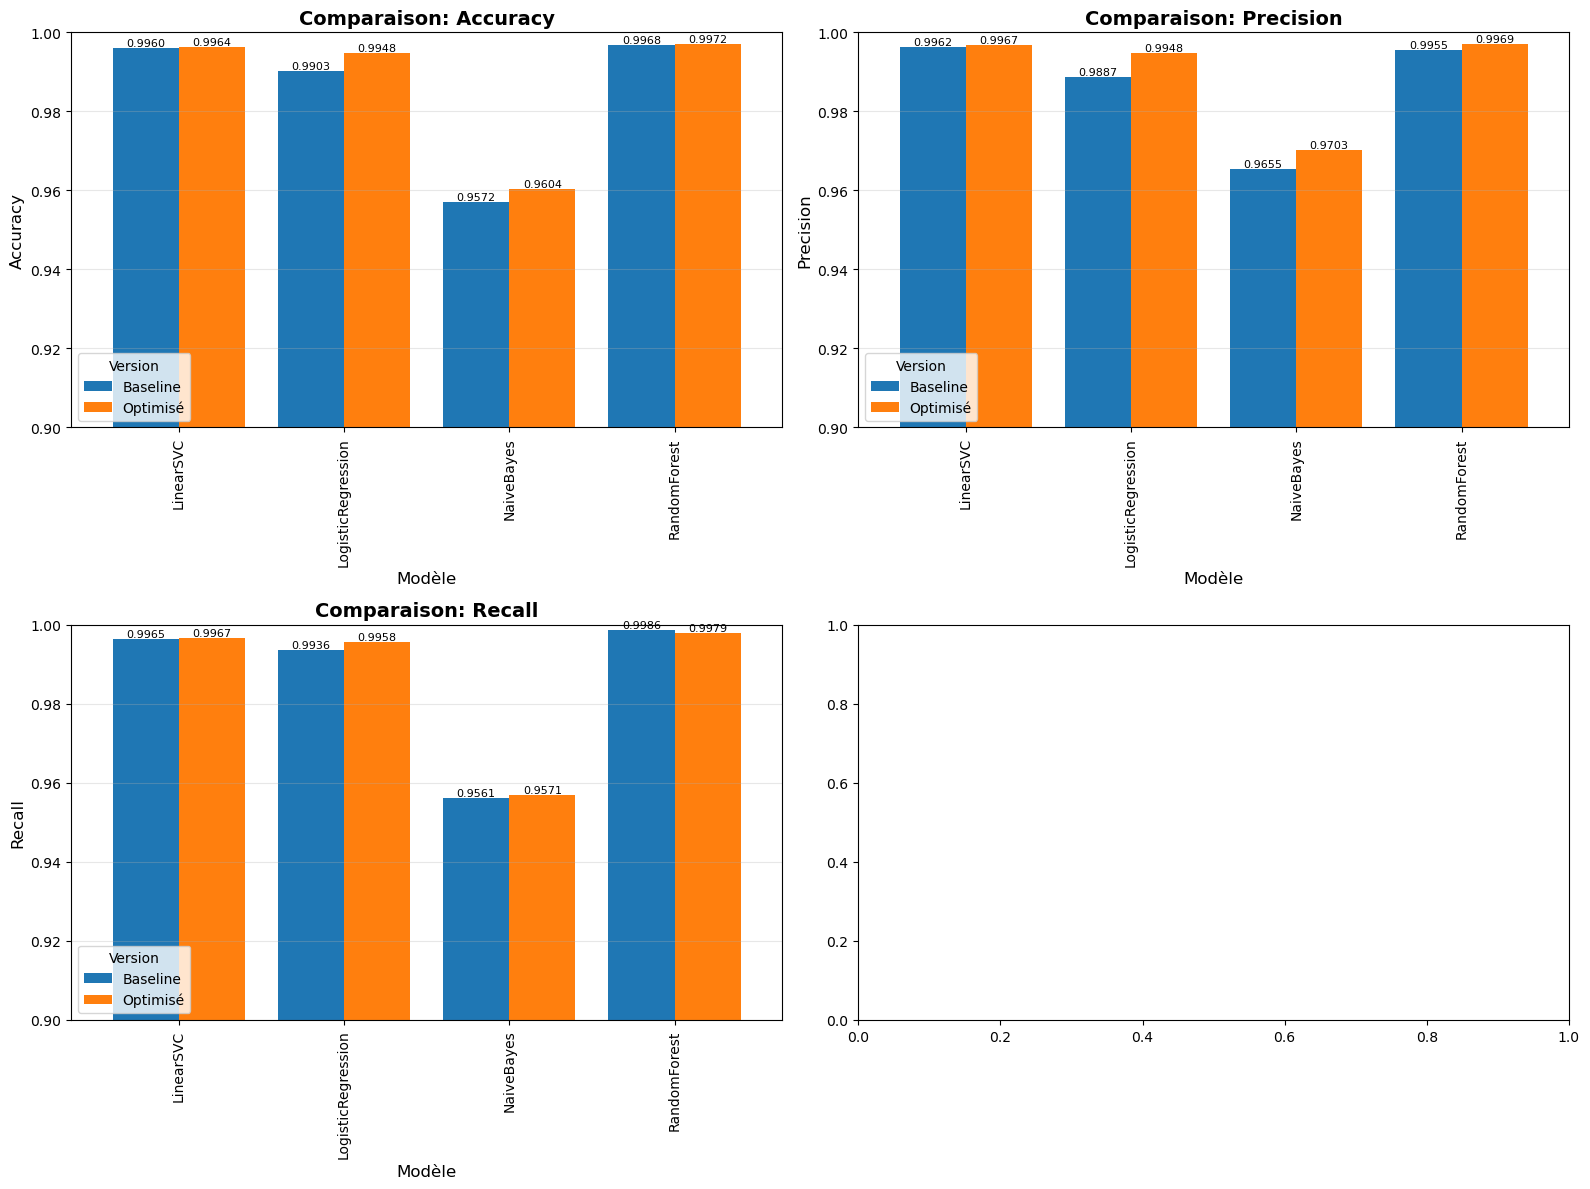

Graphiques de comparaison sauvegardés


In [28]:
# Graphique de comparaison
metrics = ['Accuracy', 'Precision', 'Recall']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    df_metric = df_comparison.pivot(index='Modèle', columns='Version', values=metric)
    
    df_metric.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'Comparaison: {metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_xlabel('Modèle', fontsize=12)
    axes[idx].legend(title='Version', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.9, 1.0])  # Ajuster selon vos résultats
    
    # Ajouter les valeurs sur les barres
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.4f', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/figures/comparison_baseline_vs_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphiques de comparaison sauvegardés")

## 4.9 Identification du meilleur modèle

In [29]:
# Trouver le meilleur modèle parmi tous (baseline + optimisés)
all_results = []

for model_name in optimized_results.keys():
    if model_name in baseline_results:
        all_results.append({
            'Modèle': f"{model_name} (Baseline)",
            'Accuracy': baseline_results[model_name]['accuracy']
        })
    
    all_results.append({
        'Modèle': f"{model_name} (Optimisé)",
        'Accuracy': optimized_results[model_name]['accuracy']
    })

df_all = pd.DataFrame(all_results).sort_values('Accuracy', ascending=False)


print("CLASSEMENT COMPLET DES MODÈLES (par Accuracy)")

print(df_all.to_string(index=False))

best_model = df_all.iloc[0]

print(" MEILLEUR MODÈLE")
print("="*60)
print(f"Modèle: {best_model['Modèle']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print("="*60)

CLASSEMENT COMPLET DES MODÈLES (par Accuracy)
                       Modèle  Accuracy
      RandomForest (Optimisé)  0.997153
      RandomForest (Baseline)  0.996765
         LinearSVC (Optimisé)  0.996377
         LinearSVC (Baseline)  0.995989
LogisticRegression (Optimisé)  0.994824
LogisticRegression (Baseline)  0.990295
        NaiveBayes (Optimisé)  0.960404
        NaiveBayes (Baseline)  0.957169
 MEILLEUR MODÈLE
Modèle: RandomForest (Optimisé)
Accuracy: 0.9972


## 4.10 Sauvegarde des résultats dans Excel

In [33]:
# Créer un fichier Excel avec plusieurs feuilles
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
excel_file = f'../reports/results/model_performance_{timestamp}.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    # Feuille 1: Comparaison complète
    df_comparison.to_excel(writer, sheet_name='Comparaison', index=False)
    
    # Feuille 2: Classement
    df_all.to_excel(writer, sheet_name='Classement', index=False)
    
    # Feuille 3: Hyperparamètres optimaux
    hyperparam_data = [
        {'Modèle': 'LinearSVC', 'Paramètres': str(grid_svm.best_params_)},
        {'Modèle': 'RandomForest', 'Paramètres': str(grid_rf.best_params_)},
        {'Modèle': 'NaiveBayes', 'Paramètres': str(grid_nb.best_params_)},
        {'Modèle': 'LogisticRegression', 'Paramètres': str(grid_lr.best_params_)}
    ]
    df_hyperparam = pd.DataFrame(hyperparam_data)
    df_hyperparam.to_excel(writer, sheet_name='Hyperparamètres', index=False)
    
    # Feuille 4: Meilleur modèle
    best_summary = pd.DataFrame([{
        'Meilleur Modèle': best_model['Modèle'],
        'Accuracy': best_model['Accuracy'],
        'Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }])
    best_summary.to_excel(writer, sheet_name='Meilleur Modèle', index=False)

print(f" Résultats sauvegardés dans: {excel_file}")

 Résultats sauvegardés dans: ../reports/results/model_performance_20260210_181727.xlsx


## 4.11 Résumé final

In [35]:
print("\n" + "="*80)
print("RÉSUMÉ DE L'OPTIMISATION")
print("="*80)

print(" Fichiers générés:")
print("  - Modèles optimisés: models/*_optimized.pkl")
print(f"  - Performances: {excel_file}")
print("  - Visualisations: figures/*.png")

print(" Principaux résultats:")
print(f"  - Meilleur modèle: {best_model['Modèle']}")
print(f"  - Performance:  Acc={best_model['Accuracy']:.4f}")

# Compter les améliorations
improvements = 0
for model_name in optimized_results.keys():
    if model_name in baseline_results:
        if optimized_results[model_name]['f1'] > baseline_results[model_name]['f1']:
            improvements += 1

print(f" {improvements}/{len(optimized_results)} modèles améliorés par l'optimisation")



RÉSUMÉ DE L'OPTIMISATION
 Fichiers générés:
  - Modèles optimisés: models/*_optimized.pkl
  - Performances: ../reports/results/model_performance_20260210_181727.xlsx
  - Visualisations: figures/*.png
 Principaux résultats:
  - Meilleur modèle: RandomForest (Optimisé)
  - Performance:  Acc=0.9972
 4/4 modèles améliorés par l'optimisation
